In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import ee
import io
import tqdm
import json
import fiona
import datetime
import requests
import urllib.request

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import multiprocessing as mp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from affine import Affine
from datetime import timedelta
from rasterio import features, mask
from climata.usgs import DailyValueIO
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as shPolygon
ee.Initialize()


%load_ext autoreload
%autoreload 2

In [2]:
def get_snodas_swe(shppath,startdate,enddate, data_dir ="/Users/aakash/Desktop/SatDat/GRACE/SNODAS_GRACE_processed/" ):
    '''
    Given a path to a shapefile, compute the monthly SWE
    Input: (str) - path to shapefile
    Output: (pd.DataFrame) - monthly SWE 
    '''
    # Datetime the start/end
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    
    # Find SWE files
    files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
    files.sort()

    # Read shapefile
    with fiona.open(shppath, "r") as shapefile:
        area_geom = [feature["geometry"] for feature in shapefile]

    # Read the files, mask nans, clip to area, extract dates
    imdict = {}

    for i in tqdm(files[:]):
        date = datetime.datetime.strptime(i[-16:-8],'%Y%m%d')# Get the date 
        datestr = date.strftime('%Y%m%d') # Format date
        if date >= start and date <= end:
            src = rio.open(i) # Read file
            src2 = rio.mask.mask(src, area_geom, crop=True) # Clip to shp 
            arr = src2[0].astype(float) # read as array
            arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
            arr[arr < 0 ] = np.nan # Mask nodata vals 
            imdict[datestr] = arr/1000 # divide by scale factor to get SWE in m 
    
    all_dates = {}

    for i in dt_idx:
        date = i.strftime("%Y%m%d") 

        if date in imdict.keys():
            im = imdict[date]
        else:
            im = np.zeros_like(list(imdict.values())[0])
            im[im==0] = np.nan
        all_dates[date] = im
    
    return all_dates
            
def get_res_inflow(stid, startdate, enddate):
    '''
    Fetch the daily reservoir inflow for a CDEC reservoir ID
    Input: stid (str) - 3 letter station id (ex: ISB)
    Output: Sres - (pd.DataFrame) - the full monthly flow (km^3 / mon)
    '''
    # Download Storage (SensorNums = 65) data by query str:
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    url = '''https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01'''.format(stid)
    print(url)
    urlData = requests.get(url).content
    df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    inflow = pd.to_numeric(df.VALUE, errors='coerce')
    indf = pd.DataFrame(zip(dt_idx,inflow* 0.0283168), columns = ['date',"q_cms"]) # cfs --> CMS 
    
    return rs.col_to_dt(indf)


def df_shifted(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)


def make_plots(lagim, maxcorim, meanim, varim):
    
    # Plot lag images 
    plt.figure(figsize = (10, 17))

    # First image ###########
    plt.subplot(4,1,1)

    ax = plt.gca()
    im1 = ax.imshow(lagim)

    # create cax for cbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im1, cax=cax)
    ax.set_title("Time of peak Xcorr lag (days prior)")
    
    # Sec image ###########
    plt.subplot(4,1,2)

    ax = plt.gca()
    im1 = ax.imshow(maxcorim)

    # create cax for cbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im1, cax=cax)
    ax.set_title("Magnitude of peak Xcorr")
    
    # Third image ###########
    plt.subplot(4,1,3)
    ax3 = plt.gca()
    im3 = ax3.imshow(meanim, vmin = 0, vmax = np.max(meanim)+0.1*np.max(meanim))

    # create cax for cbar
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im3, cax=cax3)
    ax3.set_title("mean P (mm)")

    # Third image ###########
    plt.subplot(4,1,4)
    ax4 = plt.gca()
    im4 = ax4.imshow(varim)

    # create cax for cbar
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im4, cax=cax4)
    ax4.set_title("P variance")
    
    
    plt.tight_layout()
    plt.show()
    

In [3]:
# Read catchments, reservoirs
gdf = gp.read_file("../shape/sierra_catchments.shp")
outdir = "../rasters/DMET"

# Set start / end date
startdate = '2003-09-30'
enddate = '2020-10-01'
dt_idx = pd.date_range(startdate,enddate, freq='D')

In [4]:
# Big loop through all catchments to get the data, do the xcorrelation, and write files 

# Compute the cross correlation like:

# $ [f * g](t) = \sum_{i=0}^{n} f(t) g(t- \tau) $

# Get the time lag like:
### $    \tau_{lag} = argmin | [f*g] (t) | $

0
************************************************************
SHA SACRAMENTO R


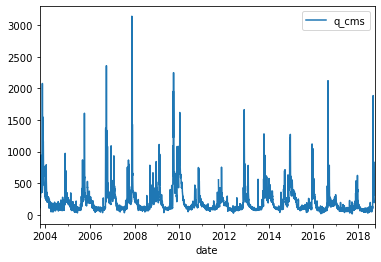

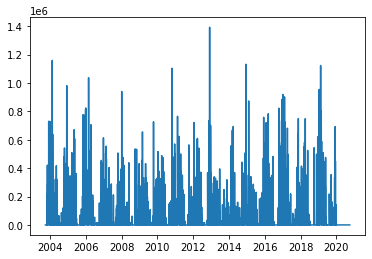

Running Xcorr...


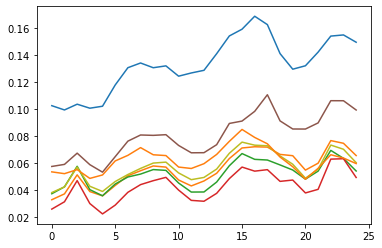

wrote ../rasters/DMET/SHA_mean.tif
wrote ../rasters/DMET/SHA_var.tif
wrote ../rasters/DMET/SHA_lag.tif
wrote ../rasters/DMET/SHA_cormax.tif


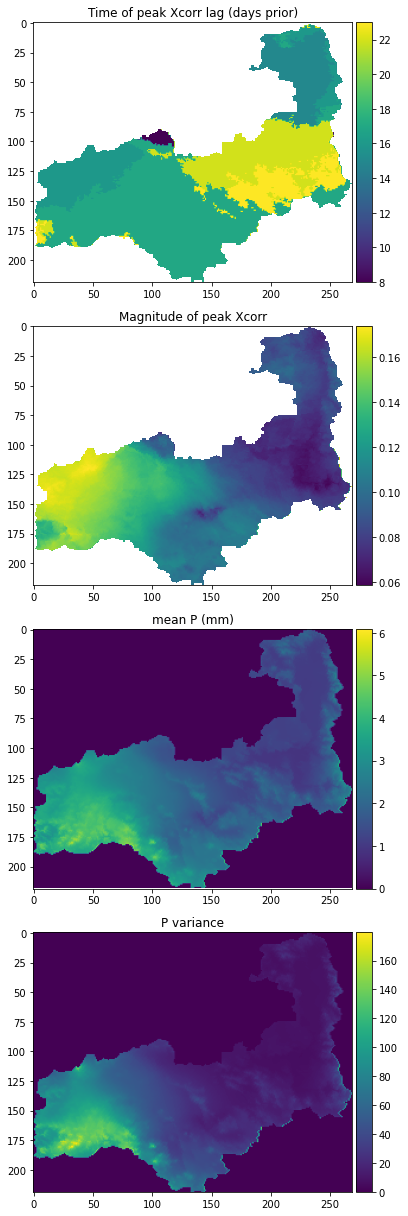

1
************************************************************
NHG CALAVERAS R


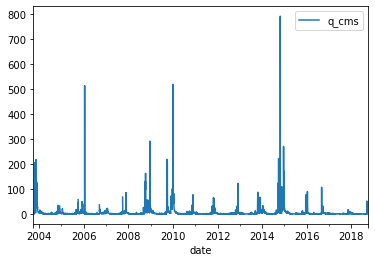

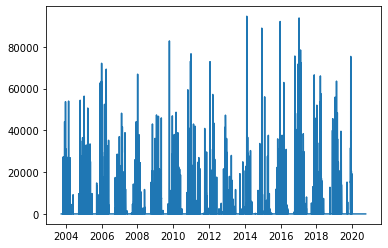

Running Xcorr...


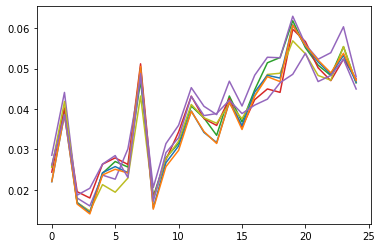

wrote ../rasters/DMET/NHG_mean.tif
wrote ../rasters/DMET/NHG_var.tif
wrote ../rasters/DMET/NHG_lag.tif
wrote ../rasters/DMET/NHG_cormax.tif


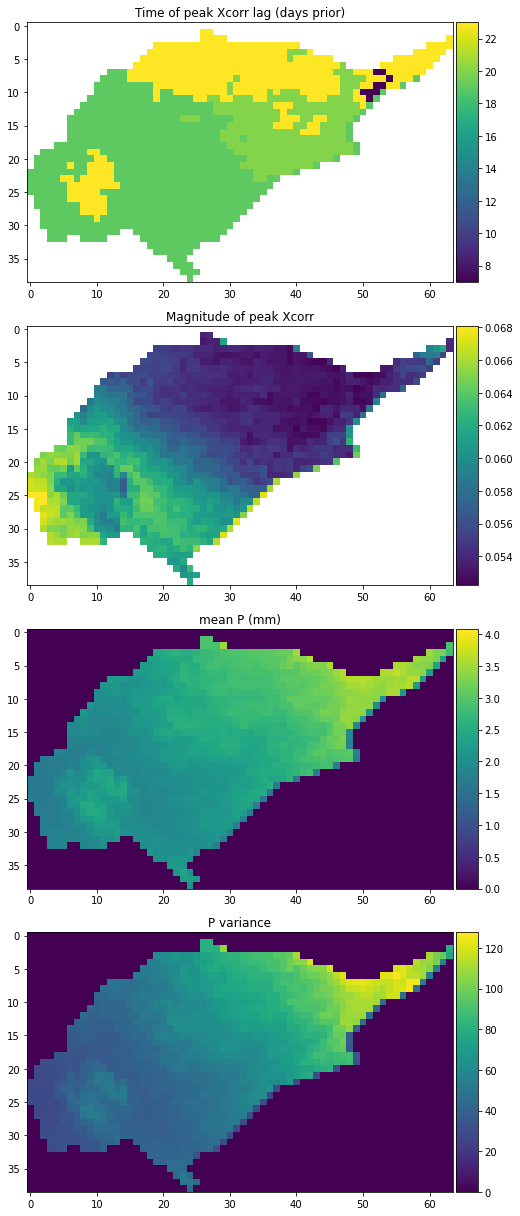

2
************************************************************
MCR MERCED R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=MCR&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01
no data for MCR
3
************************************************************
PNF KINGS R


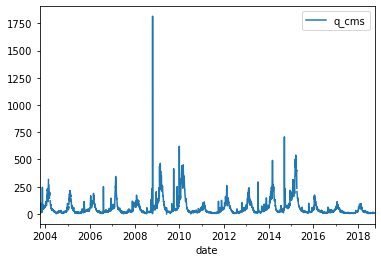

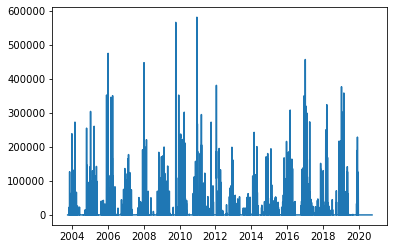

Running Xcorr...


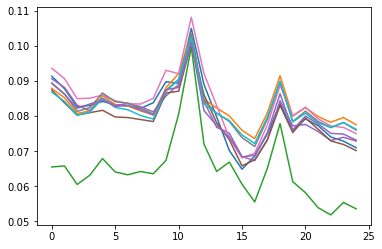

wrote ../rasters/DMET/PNF_mean.tif
wrote ../rasters/DMET/PNF_var.tif
wrote ../rasters/DMET/PNF_lag.tif
wrote ../rasters/DMET/PNF_cormax.tif


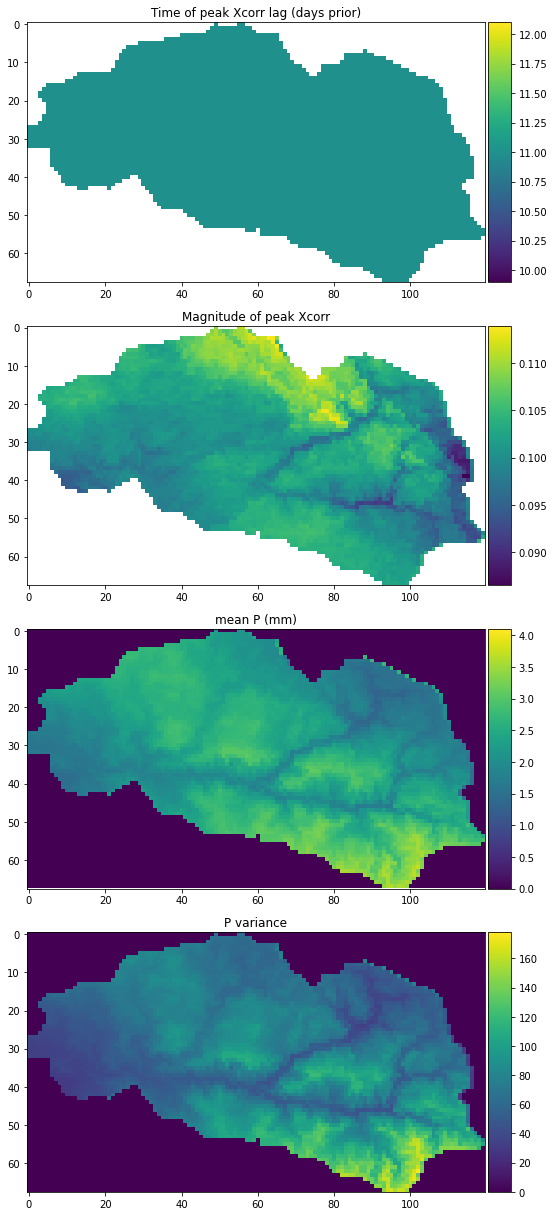

4
************************************************************
CFW BEAR R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=CFW&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01
no data for CFW
5
************************************************************
SCC TULE R


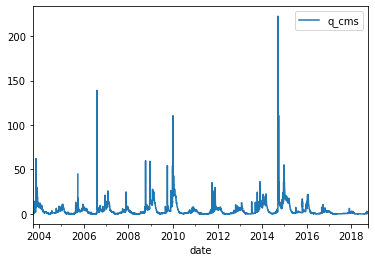

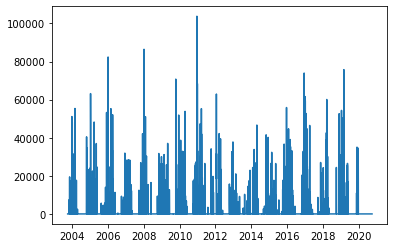

Running Xcorr...


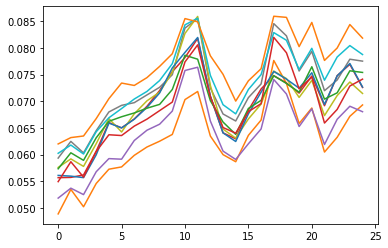

wrote ../rasters/DMET/SCC_mean.tif
wrote ../rasters/DMET/SCC_var.tif
wrote ../rasters/DMET/SCC_lag.tif
wrote ../rasters/DMET/SCC_cormax.tif


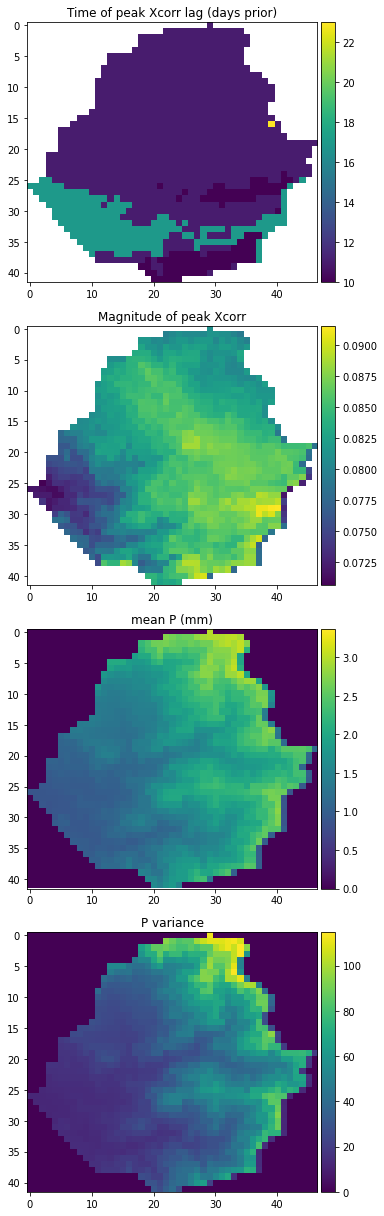

6
************************************************************
TRM KAWEAH R


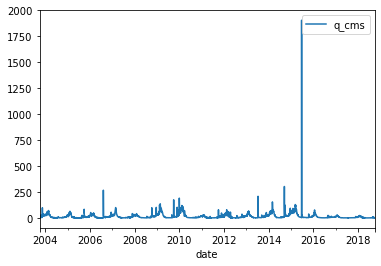

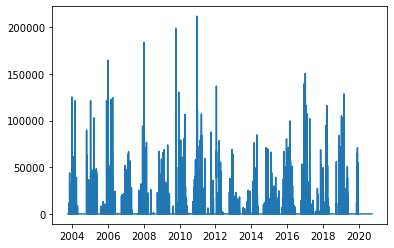

Running Xcorr...


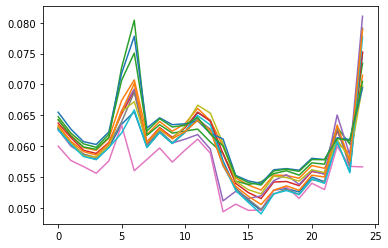

wrote ../rasters/DMET/TRM_mean.tif
wrote ../rasters/DMET/TRM_var.tif
wrote ../rasters/DMET/TRM_lag.tif
wrote ../rasters/DMET/TRM_cormax.tif


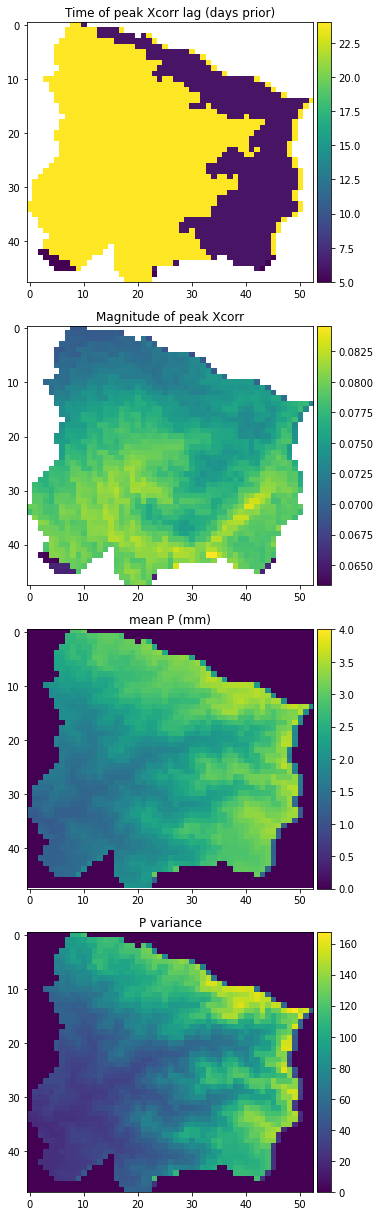

7
************************************************************
FOL AMERICAN R


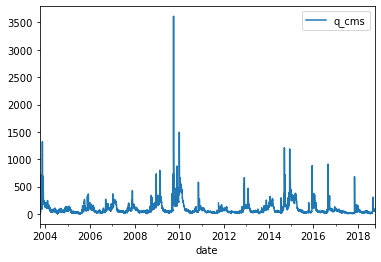

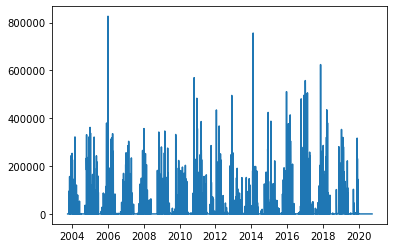

Running Xcorr...


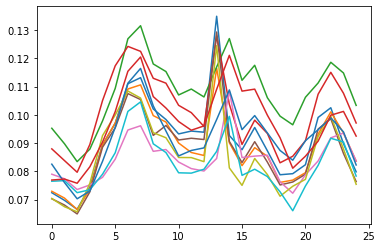

wrote ../rasters/DMET/FOL_mean.tif
wrote ../rasters/DMET/FOL_var.tif
wrote ../rasters/DMET/FOL_lag.tif
wrote ../rasters/DMET/FOL_cormax.tif


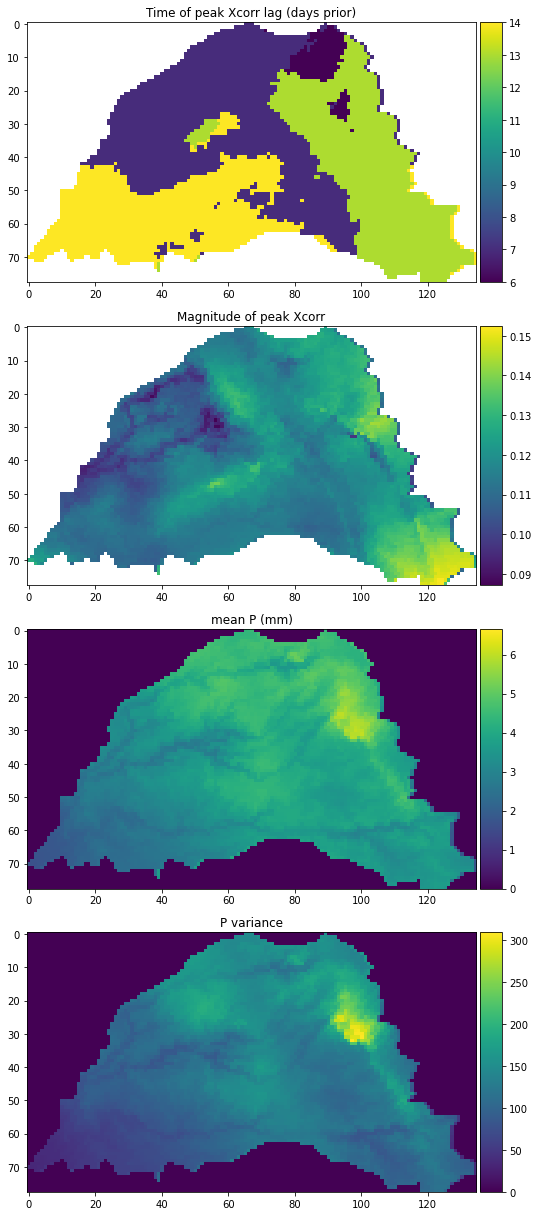

8
************************************************************
ORO FEATHER R


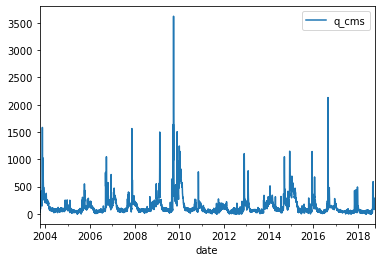

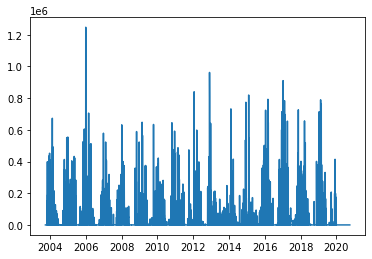

Running Xcorr...


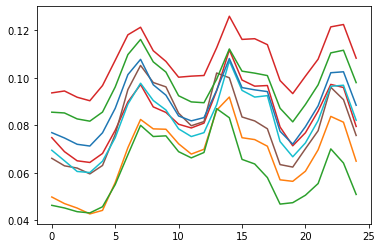

wrote ../rasters/DMET/ORO_mean.tif
wrote ../rasters/DMET/ORO_var.tif
wrote ../rasters/DMET/ORO_lag.tif
wrote ../rasters/DMET/ORO_cormax.tif


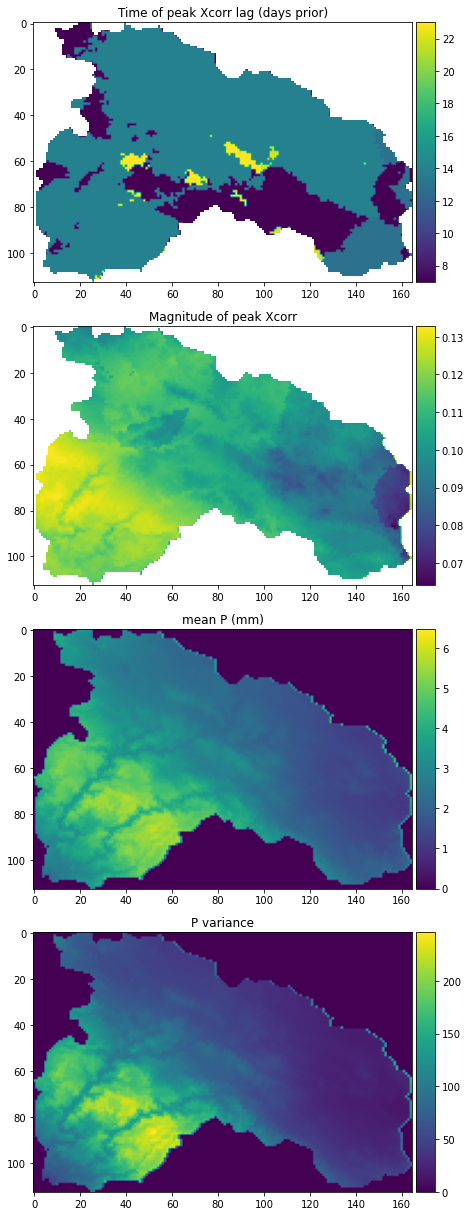

9
************************************************************
NML STANISLAUS R


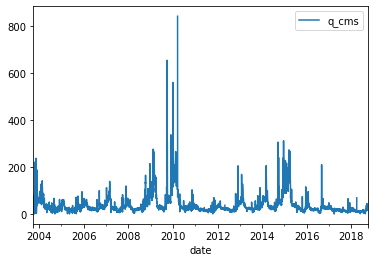

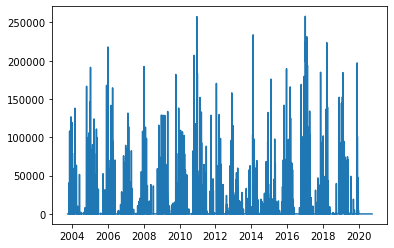

Running Xcorr...


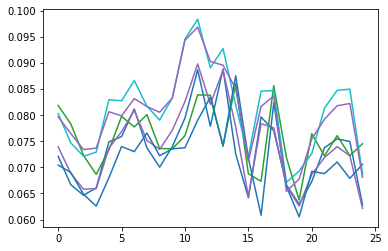

wrote ../rasters/DMET/NML_mean.tif
wrote ../rasters/DMET/NML_var.tif
wrote ../rasters/DMET/NML_lag.tif
wrote ../rasters/DMET/NML_cormax.tif


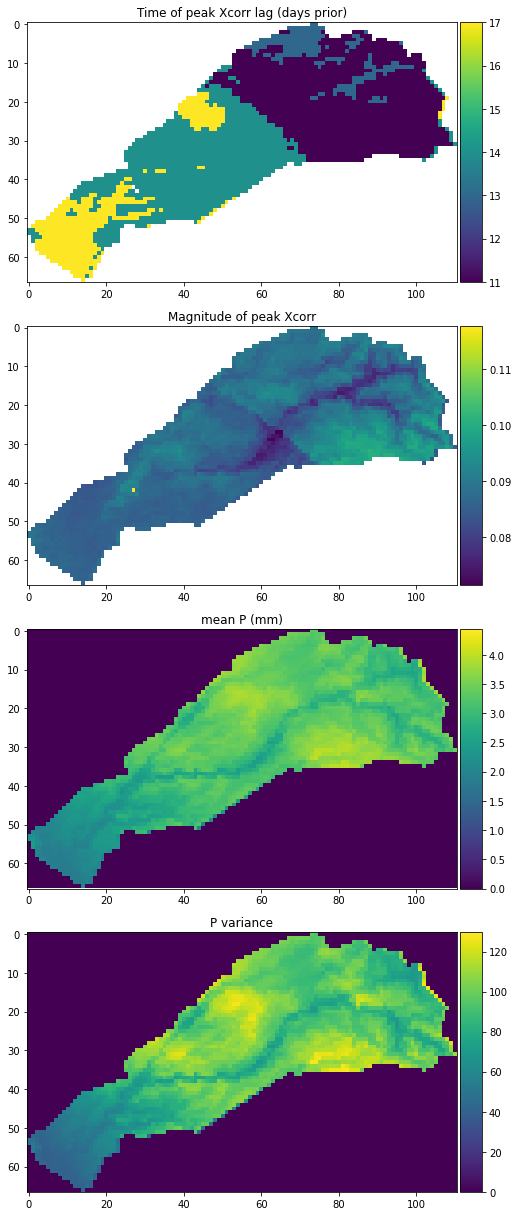

10
************************************************************
DNP TUOLUMNE R


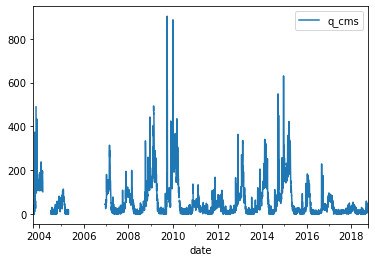

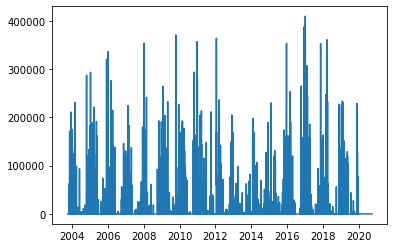

Running Xcorr...


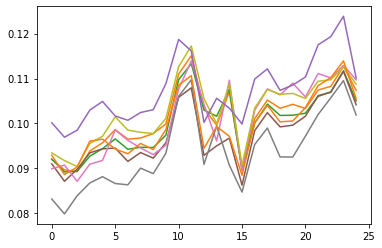

wrote ../rasters/DMET/DNP_mean.tif
wrote ../rasters/DMET/DNP_var.tif
wrote ../rasters/DMET/DNP_lag.tif
wrote ../rasters/DMET/DNP_cormax.tif


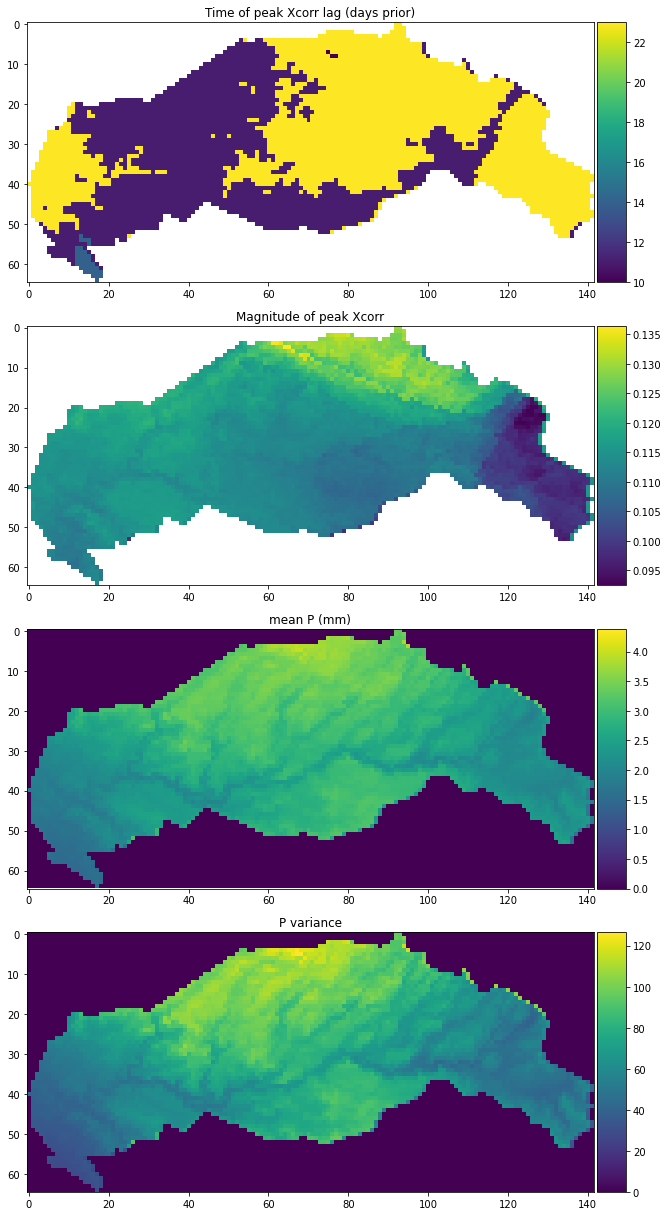

11
************************************************************
ISB KERN R


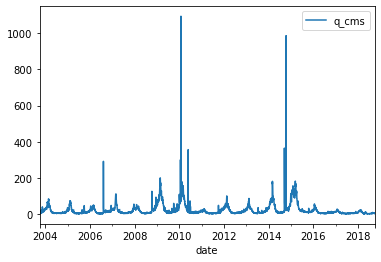

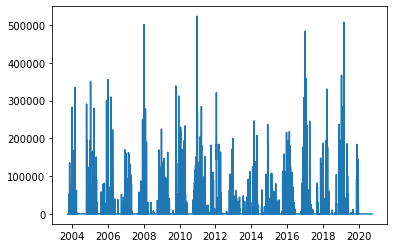

Running Xcorr...


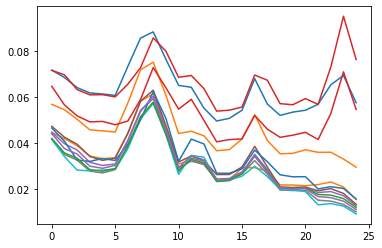

wrote ../rasters/DMET/ISB_mean.tif
wrote ../rasters/DMET/ISB_var.tif
wrote ../rasters/DMET/ISB_lag.tif
wrote ../rasters/DMET/ISB_cormax.tif


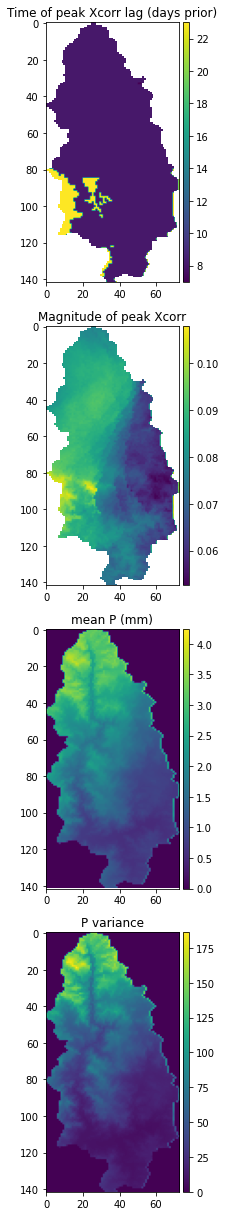

12
************************************************************
MIL SAN JOAQUIN R


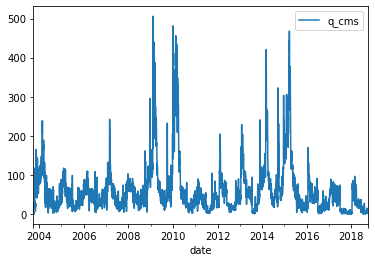

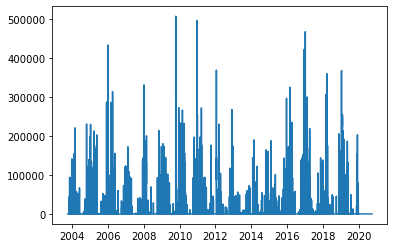

Running Xcorr...


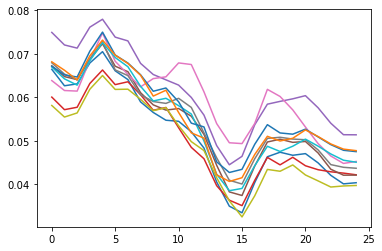

wrote ../rasters/DMET/MIL_mean.tif
wrote ../rasters/DMET/MIL_var.tif
wrote ../rasters/DMET/MIL_lag.tif
wrote ../rasters/DMET/MIL_cormax.tif


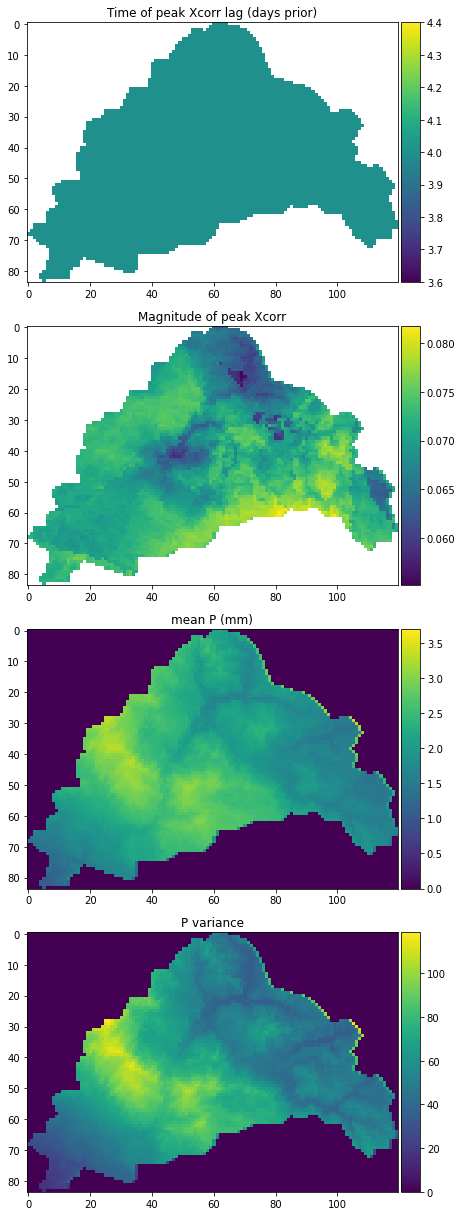

13
************************************************************
PAR MOKELUMNE R


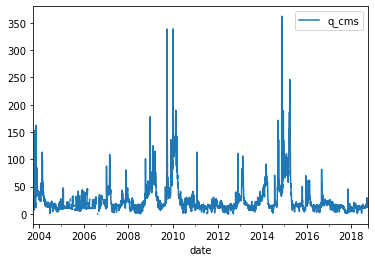

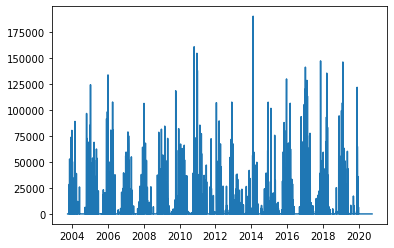

Running Xcorr...


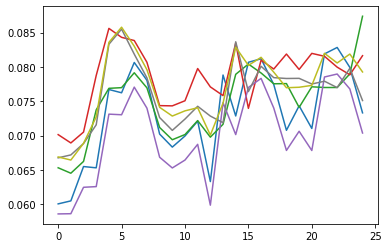

wrote ../rasters/DMET/PAR_mean.tif
wrote ../rasters/DMET/PAR_var.tif
wrote ../rasters/DMET/PAR_lag.tif
wrote ../rasters/DMET/PAR_cormax.tif


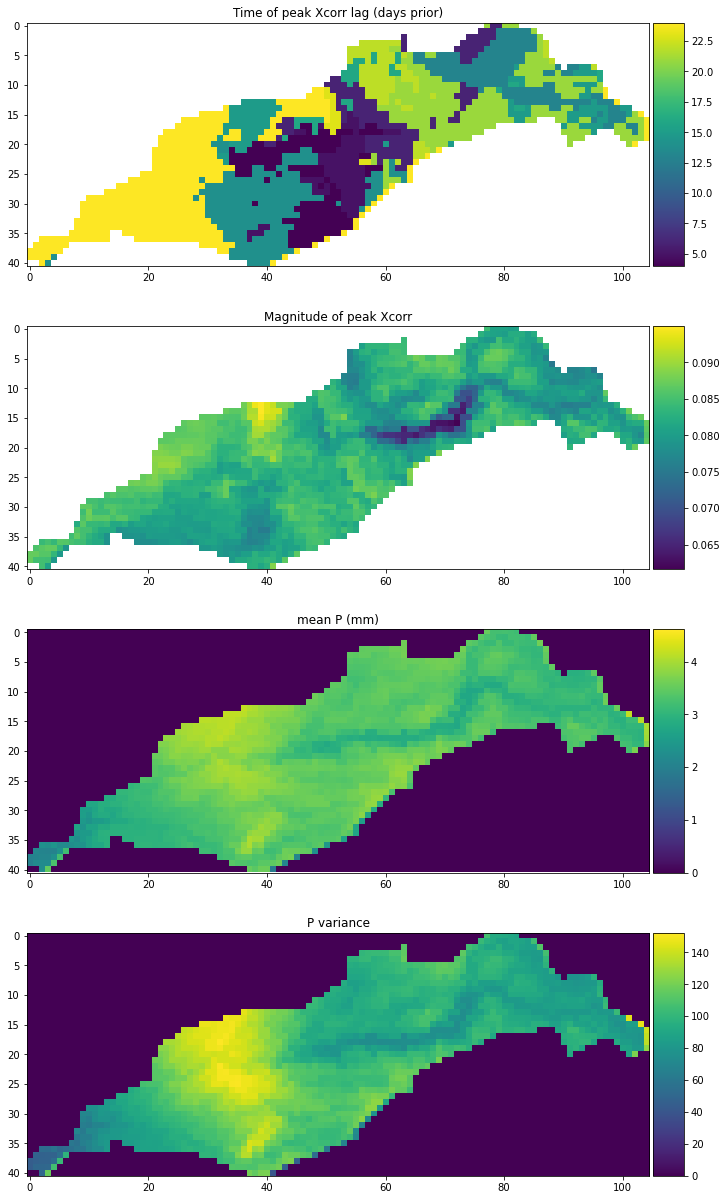

14
************************************************************
ENG YUBA R


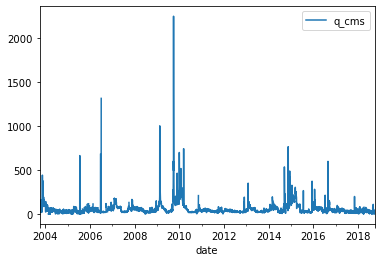

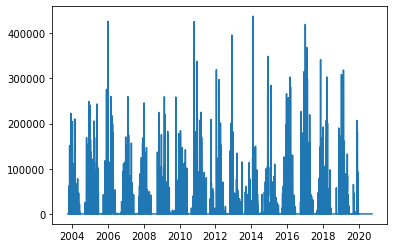

Running Xcorr...


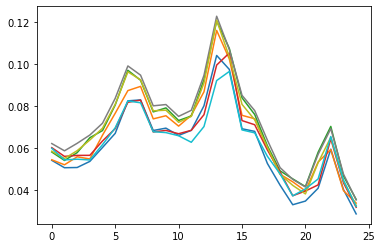

wrote ../rasters/DMET/ENG_mean.tif
wrote ../rasters/DMET/ENG_var.tif
wrote ../rasters/DMET/ENG_lag.tif
wrote ../rasters/DMET/ENG_cormax.tif


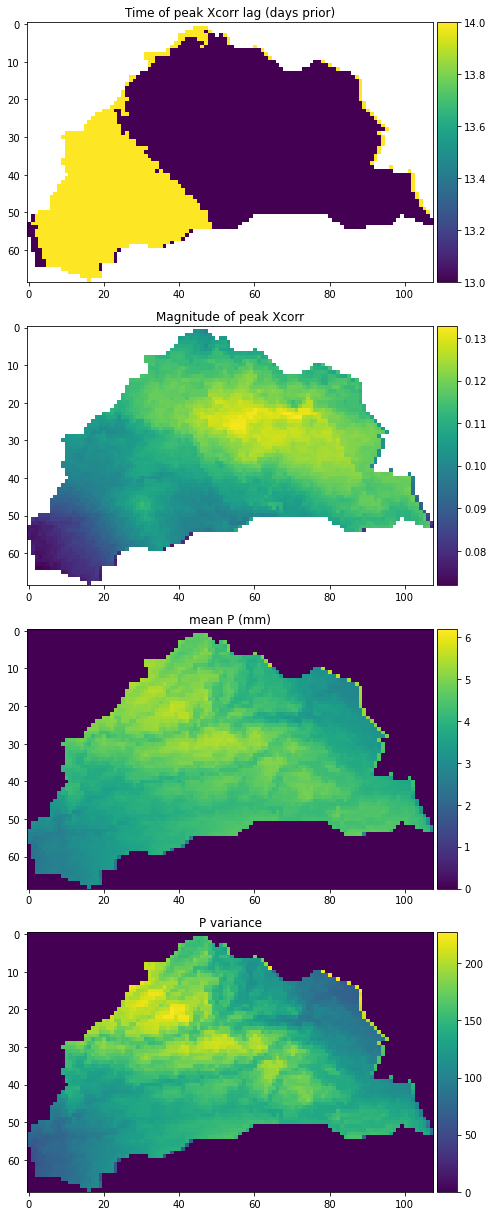

In [5]:
for idx, x in enumerate(gdf[::-1].iterrows()):
    print(idx)
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    catch_shp = "../shape/{}.shp".format(stn_id)
    print(stn_id, row['catch_name'])

    # Get the daily reservoir inflow
    outfn = os.path.join('../data/{}_res.csv'.format(stn_id))
    if not os.path.exists(outfn):
        try:
            outflow = get_res_inflow(stn_id, startdate, enddate)
            outflow.plot()
            outflow.to_csv("../data/{}_res.csv")
            plt.show()
        except:
            print("no data for {}".format(stn_id))
            continue
    else:
        outflow = rs.col_to_dt(pd.read_csv(outfn))
        outflow.plot()
        plt.show()
    
    # Get the P data
    pstack_fn = os.path.join('../data/{}_prcp.npy'.format(stn_id))
    if not os.path.exists(pstack_fn):
        rsdat = rs.load_data()
        area = rs.gdf_to_ee_poly(gp.read_file(catch_shp))
        pdat = rs.get_daily_ims(rsdat['dmet'], startdate, enddate, area, return_dates = True)
        pstack = np.dstack(list(pdat.values()))
        pvals = [pstack[:,:,t] for t in range(0, pstack.shape[2])]
        np.save(pstack_fn, pstack)

    else:
        pstack = np.load(pstack_fn)
        pvals = [pstack[:,:,t] for t in range(0, pstack.shape[2])]
        
    plt.plot(dt_idx, [np.nansum(x) for x in pvals])
    plt.show()
        
    # Format for pxlwise xcorr 
    print("Running Xcorr...")
    
    rows, cols, time = pstack.shape
    px_ts = []
    rclist = []
    
    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = pstack[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(ts_arr)
                rclist.append([row,col])

    pxdf = pd.DataFrame(px_ts).T
    pxdf.index = dt_idx
    
    # Merge the dfs
    mdf = pd.merge(outflow, pxdf, left_index = True, right_index = True)

    # Compute the cross corr 
    target = 'q_cms'
    df_new = df_shifted(mdf, target, lag=-1)
    lagged_correlation = pd.DataFrame.from_dict(
    {x: [df_new[target].corr(df_new[x].shift(-t)) for t in range(25)] for x in df_new.columns})

    # Drop the target 
    lagged_correlation.drop(['q_cms'], axis =1 , inplace = True)
    
    # Plot 15 random pixels 
    plt.plot(lagged_correlation.sample(n=15, axis=1))
    plt.show()
    
    # Find the indices of max xcorr
    lagdf = pd.DataFrame(lagged_correlation.idxmax(axis=0)).T # indices
    maxcordf = pd.DataFrame(lagged_correlation.max(axis=0)).T # values

    # Build the out image
    lagim = np.zeros_like(np.mean(pstack, axis = 2))

    # Populate the per-pixel lags 
    for rc, dfcolidx in zip(rclist,lagdf.columns):

        rowidx, colidx = rc
        val = lagdf[dfcolidx].values[0]
        lagim[rowidx,colidx] = val
        
    # Build the out image
    maxcorim = np.zeros_like(np.mean(pstack, axis = 2))

    # Populate the per-pixel max corrs 
    for rc, dfcolidx in zip(rclist,maxcordf.columns):

        rowidx, colidx = rc
        val = maxcordf[dfcolidx].values[0]
        maxcorim[rowidx,colidx] = val
    
    # Compute mean and write
    meanim = np.nanmean(pstack, axis = 2)
    varim = np.nanvar(pstack, axis = 2)
    
    # Mask zeros 
    lagim2 = np.where(lagim!=0,lagim,np.nan)
    maxcorim2 = np.where(maxcorim!=0,maxcorim,np.nan)
    meanim2 = np.where(maxcorim!=0,meanim,np.nan)
    varim2 = np.where(maxcorim!=0,varim,np.nan)
    
    # Setup Write  ims and dirs
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    lagfn = os.path.join(outdir,"{}_lag.tif".format(stn_id))
    corfn = os.path.join(outdir,"{}_cormax.tif".format(stn_id))
    meanfn = os.path.join(outdir,"{}_mean.tif".format(stn_id))
    varfn = os.path.join(outdir,"{}_var.tif".format(stn_id))

    # Write
    rs.write_raster(meanim2, gp.read_file(catch_shp), meanfn)
    rs.write_raster(varim2, gp.read_file(catch_shp), varfn)
    rs.write_raster(lagim2, gp.read_file(catch_shp), lagfn)
    rs.write_raster(maxcorim2, gp.read_file(catch_shp), corfn)

    # Plot
    make_plots(lagim2, maxcorim2, meanim2, varim2)
    

# Clip

In [6]:
# Clip the rasters to the watershed boundaries 

for idx, x in enumerate(gdf[:].iterrows()):
    print(idx)
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    print(stn_id, row['catch_name'])
    
    # Setup dirs 
    lagfn = os.path.join(outdir,"{}_lag.tif".format(stn_id))
    corfn = os.path.join(outdir,"{}_cormax.tif".format(stn_id))
    meanfn = os.path.join(outdir,"{}_mean.tif".format(stn_id))    
    varfn = os.path.join(outdir,"{}_var.tif".format(stn_id))    
    
    # Clip rasters to shp 
    catch_shp = "../shape/{}.shp".format(stn_id)
    
    for fn in [lagfn,corfn,meanfn,varfn]:
        outfn = fn[:-4] + "_cl.tif"
        cmd = '''gdalwarp -cutline {} -crop_to_cutline -dstalpha {} {}'''.format(catch_shp, fn, outfn)
        print(cmd)
        os.system(cmd) 

0
************************************************************
ENG YUBA R
gdalwarp -cutline ../shape/ENG.shp -crop_to_cutline -dstalpha ../rasters/DMET/ENG_lag.tif ../rasters/DMET/ENG_lag_cl.tif
gdalwarp -cutline ../shape/ENG.shp -crop_to_cutline -dstalpha ../rasters/DMET/ENG_cormax.tif ../rasters/DMET/ENG_cormax_cl.tif
gdalwarp -cutline ../shape/ENG.shp -crop_to_cutline -dstalpha ../rasters/DMET/ENG_mean.tif ../rasters/DMET/ENG_mean_cl.tif
gdalwarp -cutline ../shape/ENG.shp -crop_to_cutline -dstalpha ../rasters/DMET/ENG_var.tif ../rasters/DMET/ENG_var_cl.tif
1
************************************************************
PAR MOKELUMNE R
gdalwarp -cutline ../shape/PAR.shp -crop_to_cutline -dstalpha ../rasters/DMET/PAR_lag.tif ../rasters/DMET/PAR_lag_cl.tif
gdalwarp -cutline ../shape/PAR.shp -crop_to_cutline -dstalpha ../rasters/DMET/PAR_cormax.tif ../rasters/DMET/PAR_cormax_cl.tif
gdalwarp -cutline ../shape/PAR.shp -crop_to_cutline -dstalpha ../rasters/DMET/PAR_mean.tif ../rasters/DMET/

gdalwarp -cutline ../shape/SHA.shp -crop_to_cutline -dstalpha ../rasters/DMET/SHA_mean.tif ../rasters/DMET/SHA_mean_cl.tif
gdalwarp -cutline ../shape/SHA.shp -crop_to_cutline -dstalpha ../rasters/DMET/SHA_var.tif ../rasters/DMET/SHA_var_cl.tif


# Merge rasters:


In [24]:
# Cd to outdir 

cor_merge_cmd = 'gdal_merge.py -n 0 -o {} {}'.format(os.path.join(outdir,"cor.tif"), os.path.join(outdir,"*cormax_cl.tif"))
lag_merge_cmd = 'gdal_merge.py -n 0 -o {} {}'.format(os.path.join(outdir,"var.tif"), os.path.join(outdir,"*var_cl.tif"))
var_merge_cmd = 'gdal_merge.py -n 0 -o {} {}'.format(os.path.join(outdir,"lag.tif"), os.path.join(outdir,"*lag_cl.tif"))
mean_merge_cmd = 'gdal_merge.py -n 0 -o {} {}'.format(os.path.join(outdir,"mean.tif"), os.path.join(outdir,"*mean_cl.tif"))

for cmd in [cor_merge_cmd,lag_merge_cmd, var_merge_cmd, mean_merge_cmd]:
    print(cmd)
    os.system(cmd)

gdal_merge.py -n 0 -o ../rasters/DMET/cor.tif ../rasters/DMET/*cormax_cl.tif
gdal_merge.py -n 0 -o ../rasters/DMET/var.tif ../rasters/DMET/*var_cl.tif
gdal_merge.py -n 0 -o ../rasters/DMET/lag.tif ../rasters/DMET/*lag_cl.tif
gdal_merge.py -n 0 -o ../rasters/DMET/mean.tif ../rasters/DMET/*mean_cl.tif


# Plot

In [25]:
# Read files

reservoirs = gp.read_file('../shape/term_res.shp')
catchments = gp.read_file('../shape/sierra_catchments.shp')
cv = gp.read_file('/Users/aakash/Desktop/HyDRA/shape/cv.shp')

lagim = rio.open(os.path.join(outdir,"lag.tif")).read(1)
lagim[lagim==0] = np.nan

meanim = rio.open(os.path.join(outdir,"mean.tif")).read(1)
meanim[meanim==0] = np.nan

corim = rio.open(os.path.join(outdir,"cor.tif")).read(1)
corim[corim==0] = np.nan

varim = rio.open(os.path.join(outdir,"var.tif")).read(1)
varim[varim==0] = np.nan

# get bbox of data 
imextent = rio.open(os.path.join(outdir,"mean.tif")).bounds
lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]


In [17]:
# Filter SWE < 0.05 m / y
# swemask= np.where(sweim > 0.005, sweim, np.nan)
# lagmask= np.where(sweim > 0.005, lagim, np.nan)
# cormask= np.where(sweim > 0.005, corim, np.nan)

In [18]:
def draw_polys(gdf, mpl_map, facecolor = "red",  alpha = 0.3, edgecolor = 'black', lw = 1, fill = True, zorder = 3):
    
    '''
    Turns a geopandas gdf of multipolygons into matplotlib polygon patches for friendly plotting with basemap. 
    '''
    
    for index, row in gdf.iterrows():
        lats = []
        lons = []
        for pt in list(row['geometry'].exterior.coords): 
            lats.append(pt[1])
            lons.append(pt[0])

        x, y = m( lons, lats )
        xy = zip(x,y)
        poly = Polygon(list(xy), fc=facecolor, alpha=alpha, ec = edgecolor ,lw = lw, fill = fill, zorder = zorder)
        plt.gca().add_patch(poly)

    return


def draw_points(gdf, mpl_map, sizecol = None, color = 'red', alpha = 0.7, edgecolor = None, fill = True, zorder = 4):
    '''
    Turns a geopandas gdf of points into matplotlib lat/lon objects for friendly plotting with basemap. 
    '''
    lats = []
    lons = []
    for index, row in gdf.iterrows():
         for pt in list(row['geometry'].coords): 
            lats.append(pt[1])
            lons.append(pt[0])
    
    if sizecol is None:
        sizecol = 50
    else:
        sizecol = sizecol.values
    
    m.scatter(lons, lats, latlon=True, s = sizecol, alpha=alpha, c = color, edgecolor = edgecolor, zorder = zorder)


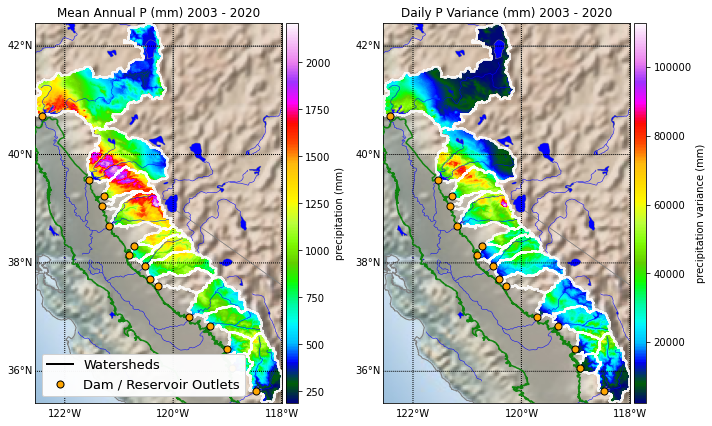

In [41]:
# Precip mean and variance 

fig = plt.figure(figsize=(10,8))

############################## First Map: Mean 
ax1 = fig.add_subplot(121)
# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(meanim)*365, cmap='gist_ncar')
ax1.set_title("Mean Annual P (mm) 2003 - 2020")

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='precipitation (mm)')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=7, 
                       markeredgecolor = 'black',markerfacecolor="orange"),
                ]

leg1 = ax1.legend(custom_lines, ["Watersheds", 'Dam / Reservoir Outlets'],
                    loc = "lower left",
                    prop={'size':13})

ax1.add_artist(leg1)

############################## Second Map: Variance 

ax2 = fig.add_subplot(122)
# Initialize the basemap
m = Basemap(ax = ax2,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(varim)*365, cmap='gist_ncar')
ax2.set_title("Daily P Variance (mm) 2003 - 2020")

# Set location of the colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='precipitation variance (mm)')

plt.tight_layout()
plt.show()

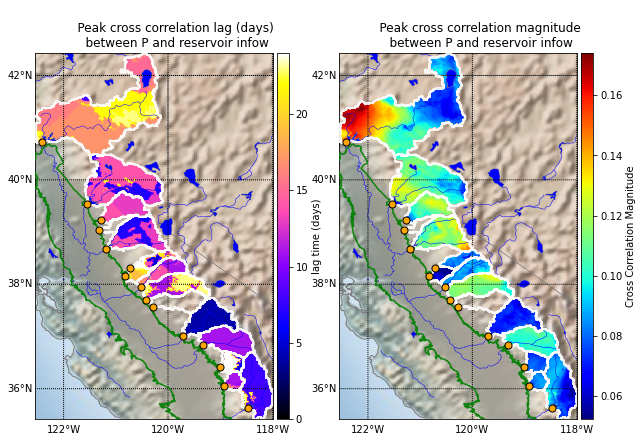

In [40]:
# Lagtime and Correlation magnitude

fig = plt.figure(figsize=(10,8))

############################## Third Map: Lagtimes 

ax3 = fig.add_subplot(121)
# Initialize the basemap
m = Basemap(ax = ax3,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(lagim),vmin = 0, cmap='gnuplot2')
ax3.set_title('''
            Peak cross correlation lag (days) 
            between P and reservoir infow''')

# Set location of the colorbar
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='lag time (days)')


############################## 4th Map: Corr Magnitudes  

ax4 = fig.add_subplot(122)
# Initialize the basemap
m = Basemap(ax = ax4,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(corim), cmap='jet')
ax4.set_title('''
            Peak cross correlation magnitude 
            between P and reservoir infow''')

# Set location of the colorbar
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='Cross Correlation Magnitude')

plt.tight_layout()
plt.show()

In [42]:
# Plot dist/ time 

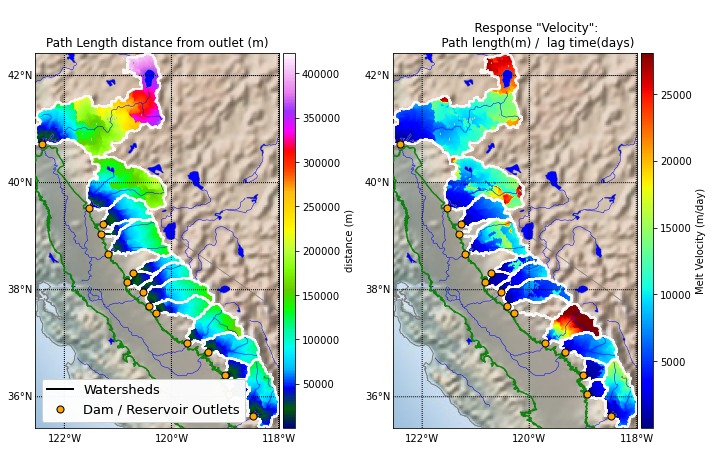

In [43]:
lagim_rs = rio.open("../rasters/DMET/lag_resamp.tif").read(1)
distim = rio.open("../rasters/flow_dist/dist.tif").read(1)
lagim_rs[lagim_rs==0] = np.nan
distim[distim==0] = np.nan
distim = distim*90 # convert n px to m

ttim = distim/lagim_rs

fig = plt.figure(figsize=(10,8))

############################## First Map
ax1 = fig.add_subplot(121)
# Initialize the basemap
m = Basemap(ax = ax1,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(distim), cmap='gist_ncar')
ax1.set_title("Path Length distance from outlet (m)")

# Set location of the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='distance (m)')

# Make the first legend (upper left of map)
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], linewidth=0, marker='o', markersize=7, 
                       markeredgecolor = 'black',markerfacecolor="orange"),
                ]

leg1 = ax1.legend(custom_lines, ["Watersheds", 'Dam / Reservoir Outlets'],
                    loc = "lower left",
                    prop={'size':13})

ax1.add_artist(leg1)

############################## Second Map



############################## 3rd Map

ax3 = fig.add_subplot(122)
# Initialize the basemap
m = Basemap(ax = ax3,epsg='4326', ellps='WGS84',resolution='f', llcrnrlon=lllon, urcrnrlon=urlon, llcrnrlat=lllat, urcrnrlat=urlat,
            lat_0= (lllat + urlat) / 2, lon_0= (lllon + urlon) / 2)

# Add stuff to basemap 
m.shadedrelief(zorder = 0)
m.drawcoastlines(color='gray', zorder = 2)
m.drawcountries(color='gray', zorder = 2)
m.drawstates(color='gray', zorder = 2)
m.drawrivers(color = "blue", zorder = 2)
m.fillcontinents(color='none',lake_color='blue', zorder = 2)

# Draw lines of latitude and longitude. Labels are like [left,right,top,bottom]
parallels = np.arange(0.,90.,2.)
meridians = np.arange(0.,360.,2.)

m.drawparallels(parallels,labels=[True,False,True,False]) # [left,right,top,bottom]
m.drawmeridians(meridians,labels=[True,False,False,True]) # [left,right,top,bottom]

# Draw the watersheds we delineated
draw_polys(catchments, m, alpha = 0.9, edgecolor = 'white', lw = 1.5, fill = False)
draw_points(reservoirs,m, alpha = 1,  color= 'orange', edgecolor = 'black')
draw_polys(cv, m, alpha = 0.9, edgecolor = 'green', lw = 1.5, fill = False)

# Plot im
im = m.imshow(np.flipud(ttim), cmap='jet', vmax = np.nanpercentile(ttim,97))
ax3.set_title('''
            Response "Velocity": 
            Path length(m) /  lag time(days)''')

# Set location of the colorbar
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mappable=im, cax=cax, label='Melt Velocity (m/day)')

plt.tight_layout()
plt.show()